In [132]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from UtilityGraph import *
from Defence import *
from Corruption import *
from UtilityMLP import *
import random
import copy
import seaborn as sns
from Test import *
import math

In [133]:
Seed = 2001  # for reproducibility
random.seed(Seed)
np.random.seed(Seed) 
torch.manual_seed(Seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(Seed)
    torch.cuda.manual_seed_all(Seed)


In [134]:
# Graph
required_probability=0.9999
num_nodes, G,A,pos,r_c=build_random_graph(200,required_probability,fix_num_nodes=True)
print("num_nodes:",num_nodes)

percentageCorrupt = 0   #Percentage of corrupt clients
corrupt = True              #If True, corrupt clients are included
CorruptClients = CorruptGeneration(percentageCorrupt, corrupt, num_nodes) #Selection of Corrupt Clients
CorruptClients = np.array(CorruptClients, dtype=int)



var = 30                  # Standard deviation for Gaussian noise
mean = 2000                    # Mean for Gaussian noise
Target = np.random.randint(1, num_nodes) # Target client for copycat attack
scale = 1
typeAttack = 1              # 0: No attack, 1: Gaussian noise, 2: Copycat attack, 3: Gaussian addative noise attack, 4: LIE attack

# Data
Data = np.zeros([num_nodes,1])
RealMean = 25
RealVar = 5
for i in range(num_nodes):
    Data[i] = np.random.normal(RealMean, np.sqrt(RealVar))

Control = Data.copy()



num_nodes: 200
IteNumber of Corrupt nodesration 0, Corrupt nodes: []


In [135]:
def normpdf(x, mn, var):
    denom = (2 * np.pi * var)**0.5 
    num = np.exp(-((x - mn)**2) / (2 * var + 1e-6)) 
    return num / (denom + 1e-6)

In [136]:
# Define the normal probability density function
def shownormpdf(mn, var):
    # Step 2: Create x values (input range)
    x = np.linspace(-10, 20, 500)  # Adjust the range to better visualize the Gaussian

    # Step 3: Compute y values (apply the function)
    y = normpdf(x,mn,var)

    # Step 4: Plot the function
    plt.plot(x, y, label='Normal PDF (mean={mn}, variance={var})'.format(mn=mn, var=var))

    # Step 5: Customize the plot
    plt.title("Plot of Normal Probability Density Function")  # Add title
    plt.xlabel("x")  # Label x-axis
    plt.ylabel("f(x)")  # Label y-axis
    plt.axhline(0, color='black', linewidth=0.5)  # Add x-axis line
    plt.axvline(0, color='black', linewidth=0.5)  # Add y-axis line
    plt.grid(True)  # Add grid
    plt.legend()

    # Step 6: Show the plot
    plt.show()
    return 0


In [137]:
def main():
    calc_mean = 0
    max_iters=1000             #PDMM max iterations (not transmissions)
    averaging = 1           #Averaging alpha
    tolerance=10^-12              #PDMM tolerance
    c=1                       #PDMM c
    
    avg_temp = np.mean(Data)
    for i in range(num_nodes):
        if CorruptClients[i] == 1:
                Data[i] = np.random.normal(mean,  np.sqrt(var))

    print(avg_temp)
    Error = []
    Error, Transmission,calc_mean = PDMM(Data, G, avg_temp, tolerance, c, max_iters,Control,averaging)
    print(calc_mean)
    plt.figure(figsize=(10, 4))
    # Plot accuracy
    plt.plot(range(len(Error)), Error, label='PDMM convergenc')
    plt.yscale('log')
    plt.title('PDMM erorr over iteration rounds')
    plt.xlabel('Iteration Round')
    plt.ylabel('Norm Error')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [138]:
def PDMM(Data, G, avg_temp, tolerance, c, max_iters,Control,averaging):
    # Create the histogram
    plt.figure(figsize=(6,4))
    plt.hist(Control, bins=20, edgecolor='black', alpha=0.7)
    plt.title("Distribution of data before corrupt clients")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    num_nodes = G.number_of_nodes()
    x=np.zeros([num_nodes,1])
    converged = False
    Error = np.array([])
    anomaly_list = set()

    #initialise A_ij
    A_ij=calc_incidence_nested(G)

    meanList= np.zeros(num_nodes)
    varList= np.zeros(num_nodes)
    #initialise z_ij and y_ij
    z = np.zeros((num_nodes, num_nodes))
    y = np.zeros((num_nodes, num_nodes))
    temp_z = np.zeros((num_nodes, num_nodes))
    dual = np.zeros((num_nodes, num_nodes))
    test = np.zeros((num_nodes, num_nodes))


    # mean_value = 40000       # Desired mean
    # std_dev = 100           # Standard deviation (adjust as needed)

    # for i in range(num_nodes):
    #     for j in G.neighbors(i):
    #         z[i][j] = np.random.laplace(loc=mean_value, scale=std_dev)

    count=0
    node_list = list(range(num_nodes))


    while not converged and count < max_iters:
        if count == 0:
            plt.figure(figsize=(10, 6))
            sns.heatmap(z, annot=False, cmap="viridis", cbar=True)  # Adjust 'annot' or 'cmap' as needed
            plt.title('PDMM z Heatmap over Nodes Rounds')
            plt.xlabel('Nodes')
            plt.ylabel('Nodes')
            plt.tight_layout()
            plt.show()

        #update x_i and y_ij
        # i = np.random.randint(0, num_nodes)
        # i = node_list[count % num_nodes]

        #update x_i
        x = Data.copy()

        for i in range(num_nodes):
            for j in G.neighbors(i):
                x[i]=x[i]-A_ij[i][j]*z[i][j]
            x[i]=x[i]/(1+c*G.degree(i))
            # print(f"x[{i}]: {x[i]}")
            #update y_ij
            for j in G.neighbors(i):
                temp_z[j][i] = y[i][j]
                y[i][j]=z[i][j]+2*c*(x[i]*A_ij[i][j])
            # print(f"y[{i}]: {y[i]}")


            mean_estimate_plus = 0
            var_estimate_plus = 0
            mean_sum_plus = 0
            var_sum_plus = 0
            Alert = 0


            ## Y is being recieved by the neighbours of i
        for i in range(num_nodes):
            for j in G.neighbors(i):
                dual[j][i] = (y[j][i] + temp_z[j][i])/2 
                test[j][i] = (dual[j][i] - temp_z[j][i])/(c * A_ij[i][j] * -1)
                # if count % 50 == 0 and count < 300 or count == max_iters-1:
                    # print(f"x[{j}] = {x[j]} and x[j] calculated at {i} = {test[j][i]} with count = {count}") 

            if count > num_nodes:
                for j in G.neighbors(i):
                    if j not in anomaly_list:
                        Alert += 1
                        # mean_sum_plus += np.abs(y[j][i])
                        mean_sum_plus += dual[j][i]
                mean_estimate_plus = mean_sum_plus / (Alert)
                meanList[i] = mean_estimate_plus
                Alert = 0

                for j in G.neighbors(i):
                    if j not in anomaly_list:
                        Alert += 1
                        # var_sum_plus += (np.abs(y[j][i]) - mean_estimate_plus) ** 2
                        var_sum_plus += (dual[j][i] - mean_estimate_plus) ** 2
                var_estimate_plus = var_sum_plus / (Alert)
                varList[i] = var_estimate_plus

        for i in range(num_nodes):
            for j in G.neighbors(i):    
                # if normpdf(y[j][i], meanList[i], varList[i])/2 > 0.03 or normpdf(y[j][i], -meanList[i], varList[i]) > 0.:
                # z[i][j]=y[j][i]
                # z[i][j]=y[j][i]
                z[i][j] = averaging * y[j][i] + (1 - averaging) * z[i][j]
                # print(f"z[{i}][{j}]: {z[i][j]}")
                # Error = np.append(Error, np.linalg.norm(diff))

        mask = np.ones(len(x), dtype=bool)
        mask[CorruptClients] = False 
        diff = (x - avg_temp)[mask]
        Error = np.append(Error, np.linalg.norm(diff))
        count = count + 1
        if np.linalg.norm(diff)< tolerance:
            print(f'Iteration {count}, Norm of difference: {Error:.8f}')
            converged = True
                

                
        dual_values = []
        for i in G.nodes():
            for j in G.neighbors(i):
                # Append the dual value for the edge (i, j)
                dual_values.append(dual[j][i])
        
        mean_dual = np.mean(dual_values)
        variance_dual = np.var(dual_values)

        # if count % 50000 == 0 or count % 50000 == 1:
        #     plot_x = np.linspace(-20, 20, 500)
        #     fx_plus = normpdf(plot_x, np.mean(meanList), np.mean(varList))
        #     fx_plus = fx_plus.reshape(-1, 1)
        #     # fx_minus = normpdf(plot_x, -np.mean(meanList), np.mean(varList))
        #     # fx_minus = fx_minus.reshape(-1, 1)
        #     dual_fx = normpdf(plot_x, mean_dual, variance_dual)


        #     # Step 2: Create the figure and plot both the histogram and PDF
        #     plt.figure(figsize=(8, 5))
        #     plt.plot(plot_x, dual_fx, label='Real PDF (mean={mn}, variance={var})'.format(mn=mean_dual, var=variance_dual), color='blue', linewidth=2)
        #     # Plot the histogram
        #     plt.hist(dual_values, bins=100, edgecolor='black', alpha=0.7, density=True, label="Histogram")

        #     # Plot the normal PDF
        #     plt.plot(plot_x, fx_plus, label='PDMM PDF (mean={mn}, variance={var})'.format(mn=np.mean(meanList), var=np.mean(varList)), color='red', linewidth=2)
        #     # plt.plot(plot_x, fx_minus, label='Normal PDF (mean={mn}, variance={var})'.format(mn=-np.mean(meanList), var=np.mean(varList)), color='blue', linewidth=2)

        #     # Step 3: Customize the plot
        #     plt.title("Distribution and Normal PDF")
        #     plt.xlabel("Value")
        #     plt.ylabel("Density")
        #     plt.axhline(0, color='black', linewidth=0.5)  # Add x-axis line
        #     plt.axvline(0, color='black', linewidth=0.5)  # Add y-axis line
        #     plt.grid(True)
        #     plt.legend()

        #     # Step 5: Show the plot
        #     plt.tight_layout()
        #     plt.show()


    plt.figure(figsize=(10, 6))
    sns.heatmap(dual, annot=False, cmap="viridis", cbar=True)  # Adjust 'annot' or 'cmap' as needed
    plt.title('PDMM y Heatmap over Nodes Rounds')
    plt.xlabel('Nodes')
    plt.ylabel('Nodes')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.heatmap(y, annot=False, cmap="viridis", cbar=True)  # Adjust 'annot' or 'cmap' as needed
    plt.title('PDMM y Heatmap over Nodes Rounds')
    plt.xlabel('Nodes')
    plt.ylabel('Nodes')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.heatmap(z, annot=False, cmap="viridis", cbar=True)  # Adjust 'annot' or 'cmap' as needed
    plt.title('PDMM z Heatmap over Nodes Rounds')
    plt.xlabel('Nodes')
    plt.ylabel('Nodes')
    plt.tight_layout()
    plt.show()
    
    return Error,count, x
    # return Error,count, np.mean(x)

24.87573044534565


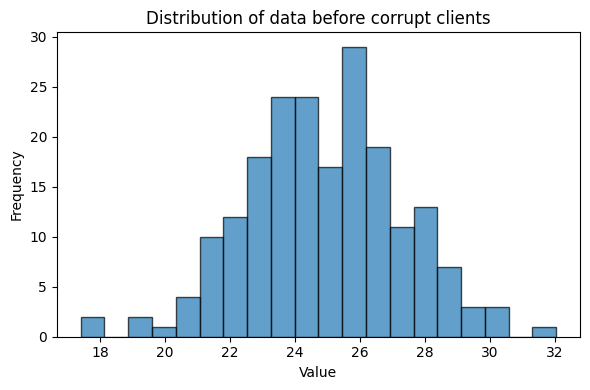

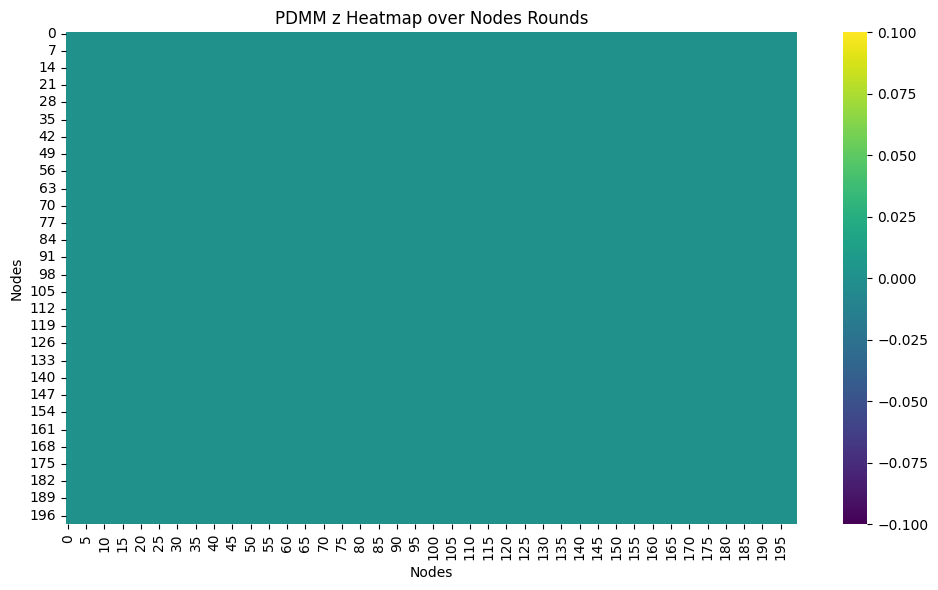

C:\Users\za_re\AppData\Local\Temp\ipykernel_10504\1601364602.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i][j]=z[i][j]+2*c*(x[i]*A_ij[i][j])


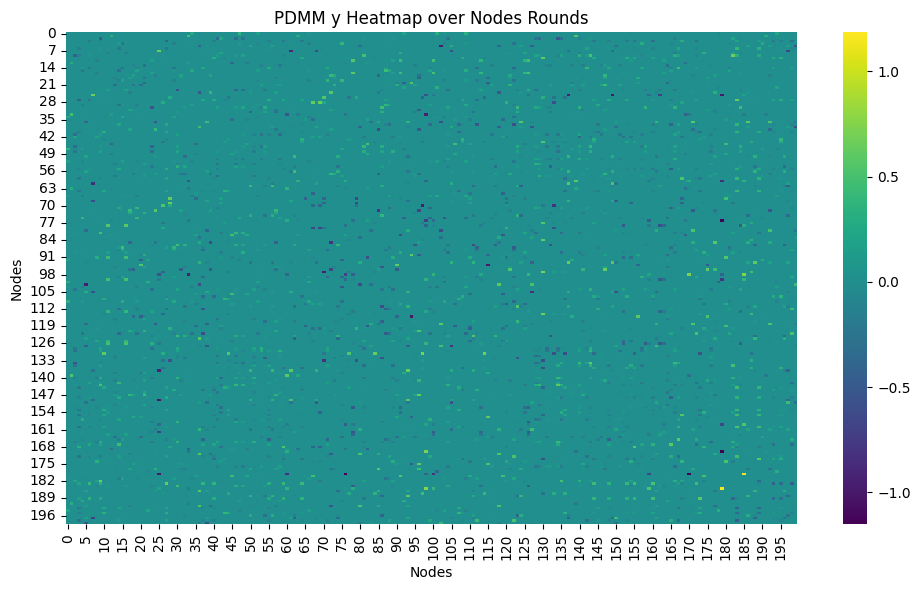

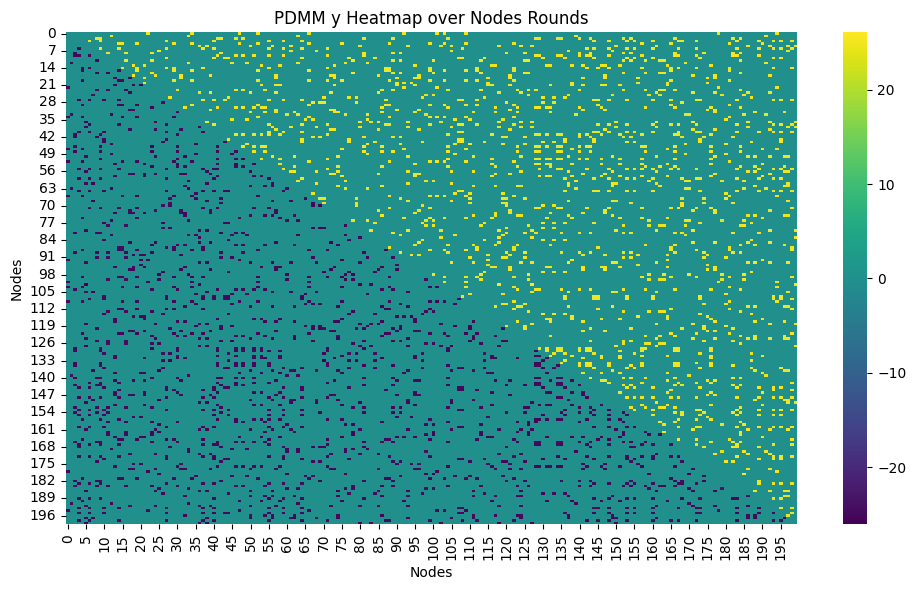

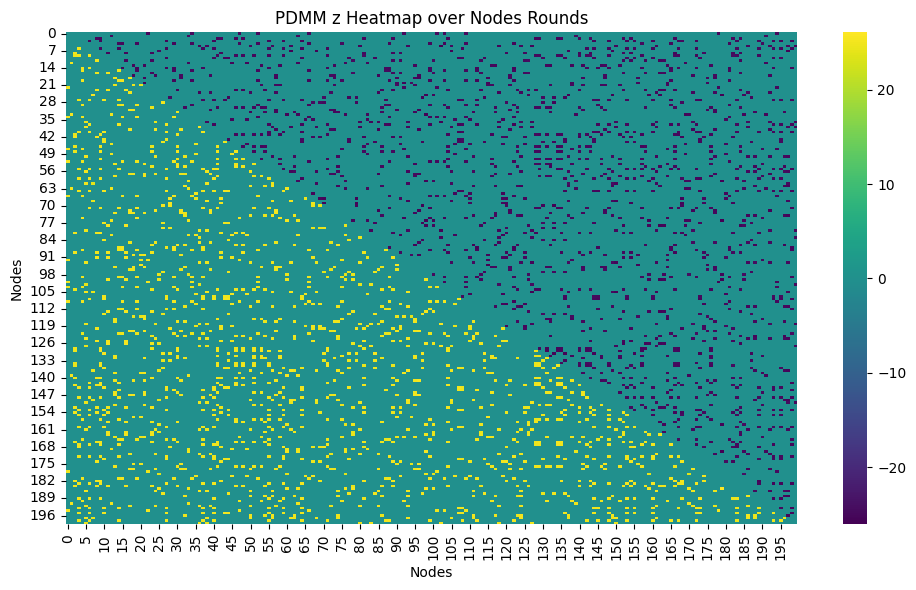

[[24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573045]
 [24.87573

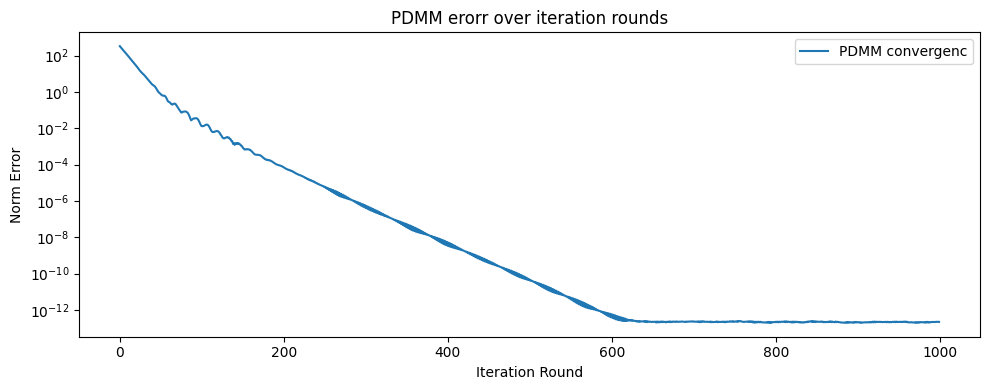

In [139]:
if __name__ == '__main__':
    main()